#### Portfolio Optimization
What is the best way to choose the subset of the set of all stocks, which optimizes financial objectives i.e., 
maximizing returns/minimizing the investment risks for an asset manager? This is what portfolio-optimization 
is about. The optimal portfolio allocation is the one that produces the maximum ratio between the return and risk. 
This problem can be stated as an optimization problem where the objective is to minimize a quadratic objective function. \ 

$C(\vec{x}) = \lambda \vec{x}^{\text{T}} \cdot \Sigma \cdot \vec{x} - (1 - \lambda) \hspace{1mm} \vec{u} \cdot \vec{x} $ 

where $\Sigma$ is the covariance matrix of the stocks (capturing the risk part of the cost function), $\vec{x}$ represents the percentage of invested capital in a given asset (normalised meaning $\Sigma_{i=1}^{N} x_{i} = 1$), $\vec{u}$ is the vector representing the expected returns of the stocks and $0 \leq \lambda \leq 1$ is the asset manager control parameter. The quadratic term represents the volatility of the chosen portfolio, while the linear one represents the expected returns. Therefore, a low value of $\lambda$ favors the expected returns of the portfolio, and high value of $\lambda$ favors low volatility; The latter is because we are minimizing the cost function and the larger positive quadratic term means larger penalties for risky portfolios. \

After mapping this problem onto an Ising model, the cost function is coded in the interaction
Hamiltonian (including zz gates in terms of spin model) whilst and the mixing unitary is there to explore the state space for minimization. This approach is often accompanied by classical optimizers to pick the best move in the state-space. \

Here, we implement and evaluate a portfolio rebalancing instance (including only 7 assests)
using a noisy quantum machine (IBM-nairobi). The most probable bit-string encodes the solution. \

Note: We are not imposing a soft or hard constraint (like having equally valued investment in each stock) which makes this solution, non-realistic, but the fact that one can impose, at least for the soft constraint, the constraint in quadratic form means that modifying the situation would be easy. \

Refs:  
(1) Hodson, M., Ruck, B., Ong, H., Garvin, D., and Dulman, S., 
    Portfolio rebalancing experiments using the Quantum Alternating Operator Ansatz, arXiv:1911.05296 \
(2) https://www.zorc-finance.com/post/optimal-portfolios-with-qaoa

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, transpile, Aer, assemble
from qiskit.tools.monitor import job_monitor

import networkx as nx
import matplotlib.pyplot as plt

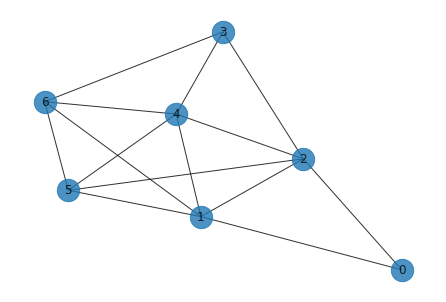

In [24]:
import networkx as nx

# The graph 
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 4), (2, 3), (2, 4), (3, 4),
                  (4, 2), (4, 5), (4, 6), (5, 1), (5, 2), (5, 4), (6, 1), (6,3), (6,5)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [25]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 7


## Mixing Unitary i.e. rotations about X 
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
# qc_mix.draw()

In [26]:
# The problem Unitary including zz gates
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
# qc_p.decompose().draw()

In [27]:
## initial State i.e. all in | + \rangle state
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
# qc_0.draw()

In [28]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

# qc_qaoa.decompose().decompose().draw()

In [29]:
# replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
IBMQ.save_account("*******", overwrite=True) 
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-26 00:16:23,693: Credentials are already in use. The existing account in the session will be replaced.


In [30]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    # Get backend for experiment
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend('ibmq_quito')


    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [31]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation,[1.0, 1.0], method='COBYLA')
res

     fun: -8.203125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([2.85633335, 0.18625827])

In [32]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_nairobi')

# prepare the circuit for the backend
qc_res = create_qaoa_circ(G, res.x)
mapped_circuit = transpile(qc_res, backend=backend)
qobj = assemble(mapped_circuit, backend=backend, shots=2048)

# execute the circuit
job = backend.run(qobj)

/var/folders/ky/942xxmk108g0y_mh6s451qxc0000gn/T/ipykernel_23585/1036274317.py:11: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


In [34]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [35]:
job.job_id()

'62df94ce656a4579ae693b8a'

In [36]:
result = job.result()
counts = result.get_counts()

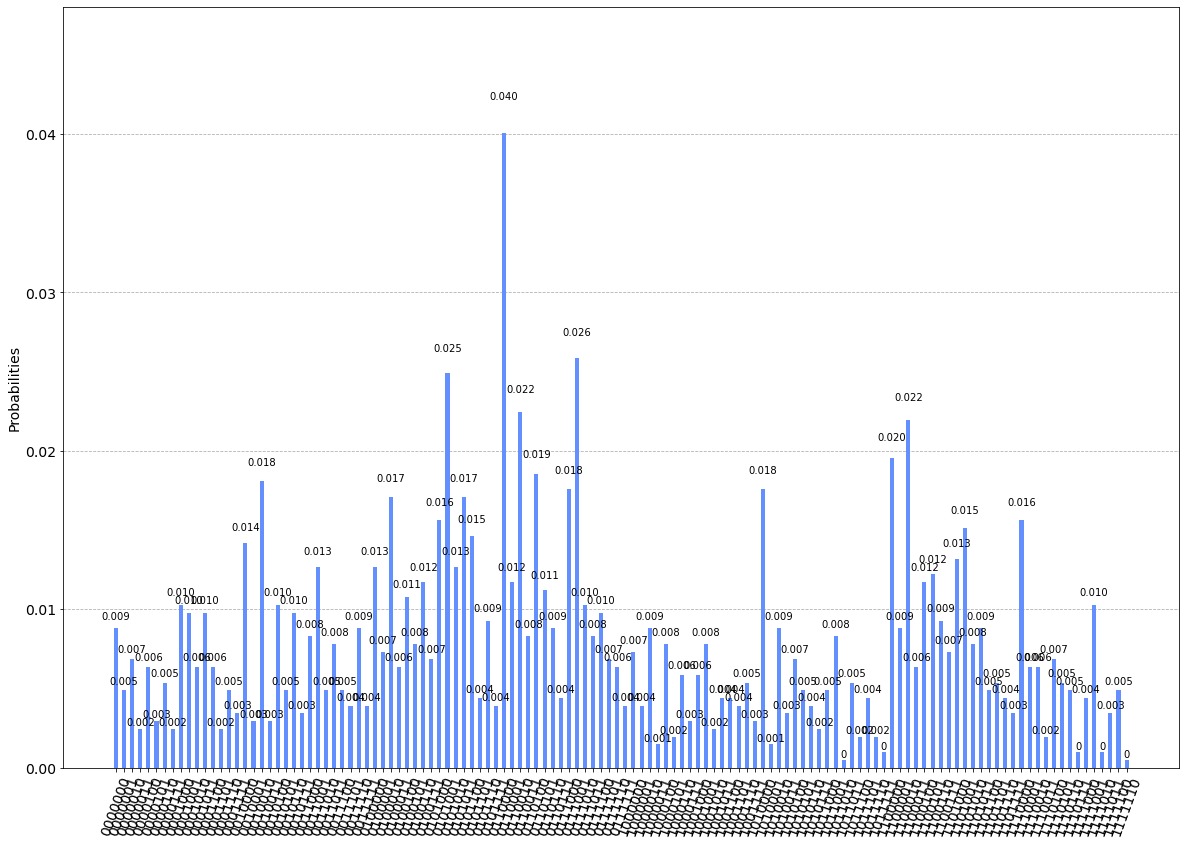

In [39]:
from qiskit.visualization import plot_histogram
plot_histogram(counts, figsize=(20,14))